In [3]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [4]:
from typing import NewType, Iterable, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from sklearn.decomposition import PCA
import cartopy.crs as ccrs

In [6]:
PROB_SEVERE = 90


def load_parquet(path: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    mask = df.columns[~df.columns.isin(("MAXRC_EMISS", "MAXRC_ICECF", "geometry"))]
    df[mask] = df[mask].astype(np.float32)
    return df


def x_and_y(df: pd.DataFrame) -> pd.DataFrame:
    """calculate geometric center of storm and fit the stom to the gridspace"""

    def generate():
        for arr in df["geometry"]:
            point = Polygon(arr.tolist()).centroid
            yield point.x, point.y

    x, y = np.array(tuple(generate()), dtype=np.float32).T
    # index position of nearest grid
    df["X"] = x
    df["Y"] = y
    return df


df_2021 = load_parquet("/workspaces/sppp/data/2021-10.parquet")
# df_2021

In [7]:
df = df_2021.pipe(x_and_y).drop(
    columns=["geometry", "MAXRC_EMISS", "MAXRC_ICECF"],  # string object float values
)
df.columns

Index(['MUCAPE', 'MLCAPE', 'MLCIN', 'EBSHEAR', 'SRH01KM', 'MEANWIND_1-3kmAGL',
       'MESH', 'VIL_DENSITY', 'FLASH_RATE', 'FLASH_DENSITY', 'MAXLLAZ',
       'P98LLAZ', 'P98MLAZ', 'WETBULB_0C_HGT', 'PWAT', 'CAPE_M10M30', 'LJA',
       'SIZE', 'MOTION_EAST', 'MOTION_SOUTH', 'PS', 'X', 'Y'],
      dtype='object')

<GeoAxesSubplot:xlabel='X', ylabel='Y'>

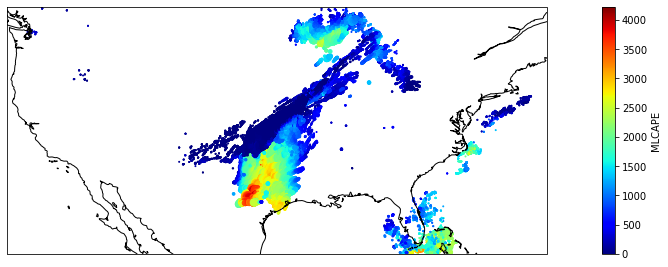

In [8]:
ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines("50m")

ax.set_extent(
    [
        *df["X"].agg(["min", "max"]),
        *df["Y"].agg(["min", "max"]),
    ],
    ccrs.PlateCarree(),
)
df.plot.scatter(
    x="X", y="Y", ax=ax, figsize=(20, 10), s="PS", cmap=plt.get_cmap("jet"), c="MLCAPE"
)